# Pronostico probabilistico para lluvia acumulada semanal.
## ¿Como generar un pronóstico probabilistico para la semana 2 con python?

En este tutorial, la idea es a partir de la latitud y longitud de un lugar:
* Encontrar el punto más cercano en el dominio SISSA de los pronósticos
* Extraer el dato de precipitación de dicho lugar para todos los miembros del ensamble
* Calcular la probabilidad de lluvia a partir de dichos datos para la semana 2 para algunos umbrales caracteristicos

Para ello vamos a trabajar con el dato en línea, tal como vimos en el tutorial [acá](https://fmcarrasco.github.io/documentation_crc_sas/SISSA_database/Tutorial_online_lista_archivos/)

Además esta vez para mayor facilidad en la extracción del dato, vamos a utilizar la librería [xarray](https://pypi.org/project/xarray/) de python.

En este caso en el próximo bloque vamos a colocar todos los datos necesarios para extraer los datos, latitud y longitud
y también los umbrales para los cuales vamos a calcular la probabilidad.

**Algunos detalles**

Para esta sección vamos a trabajar con el 02 de mayo de 2018 y la variable lluvia.

La latitud/longitud corresponde a la localidad de Mercedes, en la provincia de Corrientes, Argentina.

La idea es comparar los pronosticos de lluvias corregidos y sin corregir en términos de sus valores diarios
y también al calcular la probabilidad para la segunda semana. Se utilizan datos del SMN de la estación 
correspondiente para dicho periodo.

In [1]:
# Como siempre, partimos importando los modulos a utilizar:
%matplotlib inline
import xarray as xr
import s3fs
import netCDF4
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# DATOS
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo_corr = 'GEFSv12_corr'
modelo = 'GEFSv12'
variable = 'rain'
year = '2018'
ymd = '20180502'

PATH_corr = tforecast + '/' + modelo_corr + '/' + variable + '/' + year + '/' + ymd + '/'
PATH = tforecast + '/' + modelo + '/' + variable + '/' + year + '/' + ymd + '/'

# Colocamos como dato la latitud y longitud de la localidad:
# En este caso es Mercedes, Corrientes en Argentina.
# En la fecha que vamos a analizar ocurrio en algun momento del pronostico un evento de lluvia importante.
lat_e = -29.18
lon_e = -58.07

# Umbrales a considerar para calcular probabilidad:
umbrales = [1., 30., 50., 100.]

print('Carpeta don datos corregidos:', BUCKET_NAME + '/' + PATH_corr)
print('Carpeta don datos sin corregir:', BUCKET_NAME + '/' + PATH)


Carpeta don datos corregidos: sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/
Carpeta don datos sin corregir: sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/


In [2]:
# Vamos a hacer como en anterior, para la fecha dada, vamos a LISTAR los archivos CORREGIDOS y 
# de a cada uno, vamos a ir extrayendo el dato de pronóstico de cada ensamble

fs = s3fs.S3FileSystem(anon=True)
# Listamos todos los archivos dentro del bucket + PATH_corr
awsfiles_corr = fs.ls('s3://' + BUCKET_NAME + '/' + PATH_corr)
nfile = len(awsfiles_corr)
print('Cantidad de archivos corregidos =', nfile)

Cantidad de archivos corregidos = 11


In [3]:
# Cargamos el dato a una variable en python

list_df = []
for i, awsfile in enumerate(awsfiles_corr):
    print('Extrayendo datos del archivo:')
    print(awsfile)
    with fs.open(awsfile) as f:
        gefs = xr.open_dataset(f)
        # seleccionamos el mas cercano
        df0 = gefs.sel(lat=lat_e, lon=lon_e, method='nearest')
        # Eliminamos dimensiones con UN valor (squeeze) y transformamos a Pandas DataFrame
        df = df0[variable].squeeze().to_pandas()
        list_df.append(df)

result = pd.concat(list_df, axis=1)
print(result.head())       
    

Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_c00.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p01.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p02.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p03.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p04.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p05.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p06.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/rain/2018/20180502/rain_20180502_p07.nc
Extrayendo datos del archivo:
sissa-forecast-dat

**Algunos apuntes antes de seguir**

Vamos a realizar una figura mostrando la pluma de precipitación acumulada a lo largo de los plazos de pronóstico

Para ello utilizamos la función cumsum de la libreria pandas [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html)

En la figura vamos a remarcar en el eje X cuando hay 7 dias, de manera de tener las semanas. 

Las lineas de colores corresponden a UN miembro de ensamble y en línea negra gruesa, el acumulado observado.

Las observaciones proviene del archivo datos_mercedes.xlsx para trabajar con los datos de la estación del SMN en Mercedes, Corrientes.




(-50.0, 1000.0)

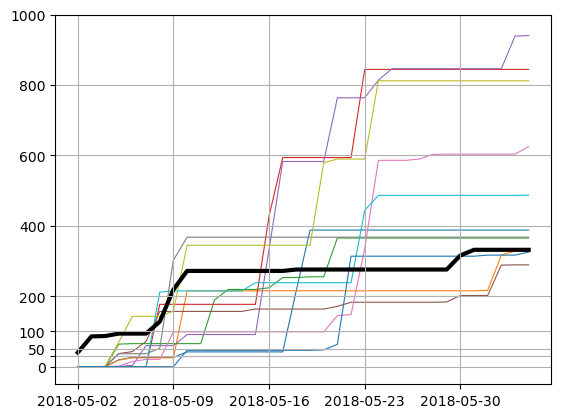

In [4]:
obs = pd.read_excel('./datos_mercedes.xlsx', usecols=['Fecha','Precipitacion', 'Tmax', 'Tmin'], engine='openpyxl')
obs = obs.set_index('Fecha').fillna(0)

# Calculamos los acumulados para observacion y pronostico corregido.
accobs = obs.cumsum()
accpp = result.cumsum()
accpp.columns = ['c00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10']


fig, ax2 = plt.subplots()

ax2.plot(accpp.index, accpp.loc[:,:].to_numpy(), zorder=0, linewidth=0.8)
ax2.plot(accobs.index, accobs.loc[:,'Precipitacion'].to_numpy(), color='k', zorder=1, linewidth=3)
ax2.set_xticks(accpp.index[0::7])
ax2.set_yticks([0, 30, 50, 100, 200, 400, 600, 800, 1000])
ax2.set_yticklabels(['0', '', '50', '100', '200', '400', '600', '800', '1000'])
ax2.grid(axis='both')
ax2.set_ylim([-50,1000])



**Apuntes**

En la figura podemos ver que hay miembros del ensamble que muestran un acumulado mucho más alto que cualquiera de los otros miembros durante todo el periodo de pronostico (34 dias).

En base a estos miembros vamos a calcular la proporcion en cada semana que se supere algún umbral de acumulado.
Vamos a utilizar 1mm y también 30mm como para tener dos estimaciones de probabilidad.

Antes tambien vamos a hacer la misma extraccion de datos, pero para los datos **SIN** correccion en la misma fecha:

In [5]:
fs = s3fs.S3FileSystem(anon=True)
# Listamos todos los archivos dentro del bucket + PATH
awsfiles = fs.ls('s3://' + BUCKET_NAME + '/' + PATH)
nfile = len(awsfiles)
list_df = []
for i, awsfile in enumerate(awsfiles):
    print('Extrayendo datos del archivo:')
    print(awsfile)
    with fs.open(awsfile) as f:
        gefs = xr.open_dataset(f)
        # seleccionamos el mas cercano
        df0 = gefs.sel(lat=lat_e, lon=lon_e, method='nearest')
        # Eliminamos dimensiones con UN valor (squeeze) y transformamos a Pandas DataFrame
        df = df0[variable].squeeze().to_pandas()
        list_df.append(df)

result_sincorr = pd.concat(list_df, axis=1)
print(result_sincorr.head())  


Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_c00.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p01.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p02.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p03.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p04.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p05.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p06.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/20180502/rain_20180502_p07.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12/rain/2018/2018

(-50.0, 1000.0)

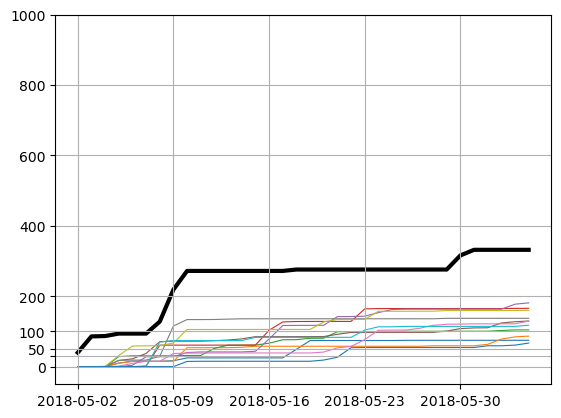

In [6]:
accpp_sincorr = result_sincorr.cumsum()
accpp_sincorr.columns = ['c00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10']


fig, ax1 = plt.subplots()

ax1.plot(accpp_sincorr.index, accpp_sincorr.loc[:,:].to_numpy(), zorder=0, linewidth=0.8)
ax1.plot(accobs.index, accobs.loc[:,'Precipitacion'].to_numpy(), color='k', zorder=1, linewidth=3)
ax1.set_xticks(accpp_sincorr.index[0::7])
ax1.set_yticks([0, 30, 50, 100, 200, 400, 600, 800, 1000])
ax1.set_yticklabels(['0', '', '50', '100', '200', '400', '600', '800', '1000'])
ax1.grid(axis='both')
ax1.set_ylim([-50,1000])

**Cálculo de probabilidad semanal por umbral**

Ahora vamos a calcular la probabilidad en distintos umbrales.

Creamos una lista colocando el numero correspondiente a la semana para agrupar.

In [7]:
lsemana = np.arange(0, len(accpp))
lsemana[0:7] = 1
lsemana[7:14] = 2
lsemana[14:21] = 3
lsemana[21:] = 4
# La ultima semana la consideramos con todos los datos que quedan posterior a la tercera semana (21 a 34 de plazo de pronostico)
# Agregamos la nueva columna
result = result.assign(i_semana = lsemana)
result_sincorr = result_sincorr.assign(i_semana = lsemana)
obs = obs.assign(i_semana = lsemana)
# Agrupamos por semana y sumamos ( ie calculamos el acumulado semanal de cada miembro del ensamble)
acc_sem = result.groupby(by='i_semana').sum()
acc_sem_sincorr = result_sincorr.groupby(by='i_semana').sum()
acc_obs = obs.groupby(by='i_semana').sum()

print(acc_sem)
print(acc_sem_sincorr)
print(acc_obs)


for semana in np.arange(0,4):
    print(' ############ Pronóstico para la semana:', semana+1, ' ############ ')
    print(' #### Lluvia observada: ', acc_obs.loc[:,'Precipitacion'].to_numpy()[semana])
    for umbral in umbrales:
        print('** Calculando probabilidad semana ' + str(semana+1) + ' para umbral:', umbral, 'mm  **')
        c0 = acc_sem[acc_sem > umbral].count(axis=1)/11
        c1 = acc_sem_sincorr[acc_sem_sincorr > umbral].count(axis=1)/11
        print('Probabilidad semana ' + str(semana+1) + ' sin corregir:', np.round(c1.to_numpy()[semana],2) )
        print('Probabilidad semana ' + str(semana+1) + ' corregida', np.round(c0.to_numpy()[semana],2) )

                   0           1           2           3           4  \
i_semana                                                               
1          26.263901   25.198363   65.492110  177.124571   59.813120   
2          15.715367  190.372088  153.883944    0.000000   31.464908   
3         346.179111    0.000000  146.227337  416.947716  672.646280   
4           0.000000  112.854193    0.000000  250.485864  176.595301   

                   5           6           7           8           9  \
i_semana                                                               
1         156.810251   20.766395   52.043809  143.028603  211.645382   
2           6.916709   78.172491  315.860148  201.824792   26.811859   
3          19.355273   49.140596    0.000000  244.963303    0.000000   
4         106.176080  477.167165    0.000000  222.339360  248.958672   

                  10  
i_semana              
1           0.000000  
2          46.472968  
3         267.398382  
4          11.53467

**Graficos para presentar el pronóstico**

Hagamos lo mismo pero con un grafico de barras con la probabilidad para cada semana.

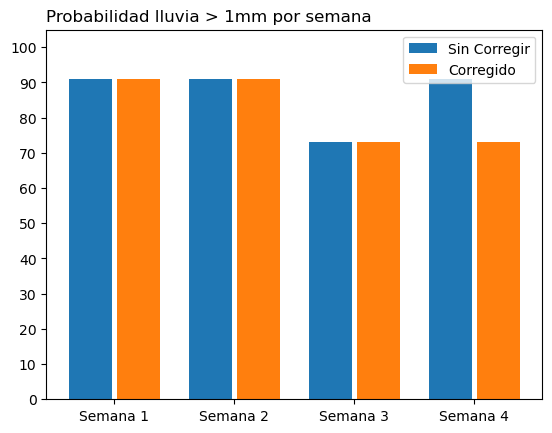

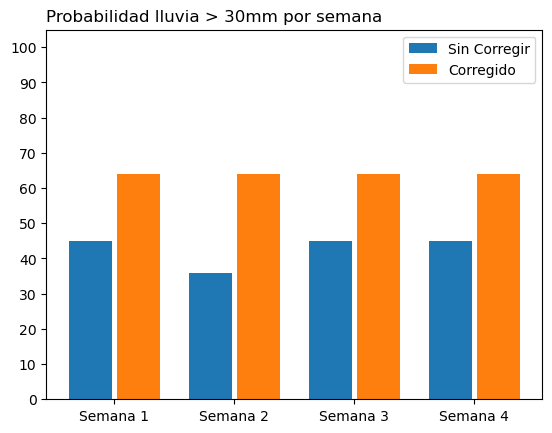

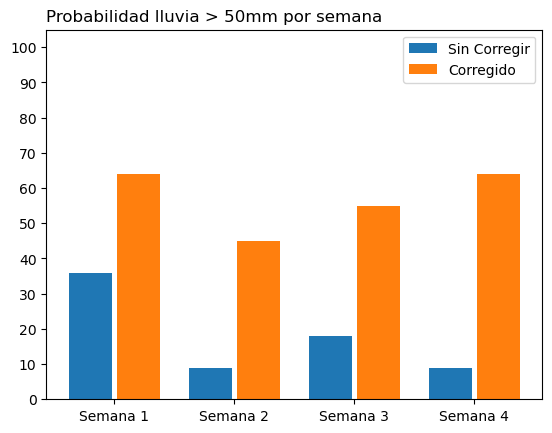

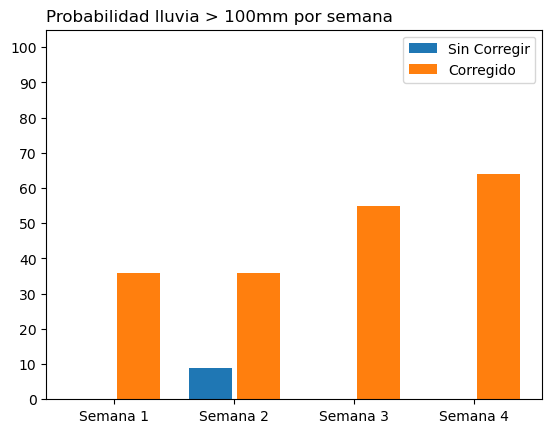

In [22]:
p_sincorr = np.empty((4,len(umbrales)))
p_sincorr[:] = np.nan
p_corr = np.empty((4,len(umbrales)))
p_corr[:] = np.nan

for semana in np.arange(0,4):
    for i, umbral in enumerate(umbrales):
        c0 = acc_sem[acc_sem > umbral].count(axis=1)/11
        c1 = acc_sem_sincorr[acc_sem_sincorr > umbral].count(axis=1)/11
        p_corr[i, semana] = np.round(c0.to_numpy()[semana],2)
        p_sincorr[i, semana] = np.round(c1.to_numpy()[semana],2)
        

#### Figura para el primer umbral
x1 = np.array([-0.2, 0.8, 1.8, 2.8])
x2 = x1+0.4

fig, ax0 = plt.subplots()

ax0.bar(x1, p_sincorr[0,:]*100, width=0.36, zorder=0, label='Sin Corregir')
ax0.bar(x2, p_corr[0,:]*100, width=0.36, zorder=0, label='Corregido')
ax0.set_xticks(np.arange(0,4))
ax0.set_xticklabels(['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4'])
ax0.set_ylim([0,105])
ax0.set_yticks(np.arange(0,110,10))
ax0.set_title('Probabilidad lluvia > 1mm por semana', loc='left')
ax0.legend()


#### Figura para el segundo umbral

fig, ax0 = plt.subplots()

ax0.bar(x1, p_sincorr[1,:]*100, width=0.36, zorder=0, label='Sin Corregir')
ax0.bar(x2, p_corr[1,:]*100, width=0.36, zorder=0, label='Corregido')
ax0.set_xticks(np.arange(0,4))
ax0.set_xticklabels(['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4'])
ax0.set_ylim([0,105])
ax0.set_yticks(np.arange(0,110,10))
ax0.set_title('Probabilidad lluvia > 30mm por semana', loc='left')
ax0.legend()

#### Figura para el segundo umbral

fig, ax0 = plt.subplots()

ax0.bar(x1, p_sincorr[2,:]*100, width=0.36, zorder=0, label='Sin Corregir')
ax0.bar(x2, p_corr[2,:]*100, width=0.36, zorder=0, label='Corregido')
ax0.set_xticks(np.arange(0,4))
ax0.set_xticklabels(['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4'])
ax0.set_ylim([0,105])
ax0.set_yticks(np.arange(0,110,10))
ax0.set_title('Probabilidad lluvia > 50mm por semana', loc='left')
ax0.legend()


#### Figura para el segundo umbral

fig, ax0 = plt.subplots()

ax0.bar(x1, p_sincorr[3,:]*100, width=0.36, zorder=0, label='Sin Corregir')
ax0.bar(x2, p_corr[3,:]*100, width=0.36, zorder=0, label='Corregido')
ax0.set_xticks(np.arange(0,4))
ax0.set_xticklabels(['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4'])
ax0.set_ylim([0,105])
ax0.set_yticks(np.arange(0,110,10))
ax0.set_title('Probabilidad lluvia > 100mm por semana', loc='left')
ax0.legend()
